In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

hour_result = pd.read_csv('../../model/output/check_hour.csv')
input_data = pd.read_csv('../../model/input/ricca_test_wind0.csv')
gasex_param = pd.read_csv('gasex_param.csv')

In [2]:
##### Constants
KELVIN   = 273.15       # Kelvin temperature
R        = 8.314        # ideal gas constant
SBC      = 5.6697e-8    # Stefan-Boltzmann constant   W m-2 K-4
PSC      = 6.66e-4      # psychrometer constant
Cp       = 29.3         # specific heat of air    J mol-1 C-1
LAMBDA   = 44000.       # Latent heat of vaporization at 25 C J mol-1
##### Parameters for light
scatt   = 0.15          # leaf reflectance + transmittance
f       = 0.15          # correction factor
conv    = 4.57          # conversion from W m-2 to umol m-2 s-1
epsilon = 0.97          # leaf thermal emissivity
##### Other Common parameters
O2    = 210.            # O2 partial pressure (mbar=20.5kPa)
Kc25  = 404.9           # MM constant of Rubisco for CO2 at 25 from Bernacchi et al. (2001)
Ko25  = 278.4           # MM constant of Rubisco for O2 at 25 from Bernacchi et al. (2001)
Eac   = 79430.  # Activation energy for Kc from Bernacchi et al. (2001)
Eao   = 36380.  # Activation energy for Ko from Bernacchi et al. (2001)
g0    = 0.036    # residual stomatal conductance,  mol m-2 s-1
g1    = 10.0    # empirical coefficient of BWB model  이거
P     = 1.013   # conversion factor from ppmv to ubar (= 1013000 / 1000000) = 101.3 kPa = 1013 mbar

## parameter for water stress
s_f    = 0.5     # sensitivity
psi_f  = -1.0
psi_th = -0.8    # threshold wp below which stress effect shows up

##########################################################
##### Parameters for Chinese cabbage from Experiment 2015
##########################################################
theta   = 0.7       # hyperbola parameter 이거
width   = 0.1        # leaf width (m) 이거
Vcm25   = 152.5     # Vcmax of CC at 25 C 이거
Jm25    = 238.6      # Jmax  of CC at 25 C 이거
TPU25   = 17.1       # 이거F
Rd25    = 1.7        # 이거
gamma25 = 42.8        #
Havcm   = 65330     # Ha
#Hdvcm   = 149252.    # Hd
#Svvcm   = 486.       # Sv
Hajm    = 57500     # Ha
Hdjm    = 439800.    # Hd
Svjm    = 1400      # Sv
Ear     = 46390.     # Ha
Eagamma = 37830.     # Ha
EaTPU   = 47100.     # Ha for TPU   from Kim and Leith(2003)

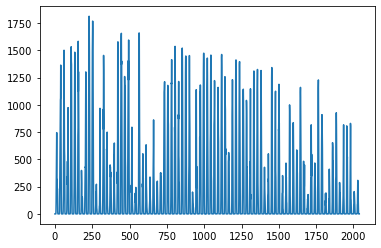

In [34]:
PPFD = input_data['Irrad'].tolist()
PPFD = [x * 4.57 / 2 for x in PPFD]
Ta = input_data['Tair'].tolist()
RH = input_data['RH'].tolist()
wind = input_data['wind'].tolist()

Ca = 400 * 1.013
predawn = 0

An = gasex_param['An'].tolist()
Tlnew = gasex_param['newtleaf'].tolist()

Ic = PPFD
Tleaf = Tlnew
plt.plot(PPFD);

BWB

In [4]:
## gbw()
gbw = []

for i in range(len(wind)):
    gbw.append(0.147 * np.sqrt(max(0.4,wind[i])/(0.72 * width)))

In [32]:
## gbc
gbc = []

for i in range(len(gbw)):
    gbc.append(gbw[i]/1.37)

In [6]:
## LWPeffect
stress = min(1.0, (1+np.exp(psi_f*s_f)) / (1+np.exp(s_f*(psi_f-(predawn-psi_th)))))

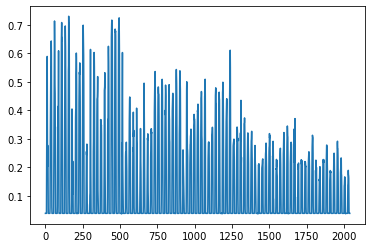

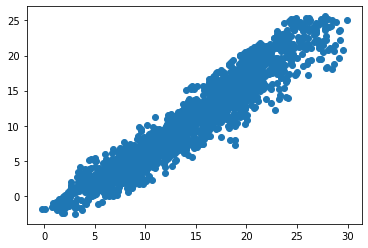

In [27]:
## gsc
gsc = []

Ha = []
Cs = []
ah = []
bh = []
ch = []
hs = []
es_Tleaf = []
Ds = []

# print(Ca)
for i in range(len(An)):
    Ha.append(RH[i]/100)
    Cs.append(Ca - An[i]/ gbc[i] * 1.013)
    # print(Cs[i])
    if Cs == 0: Cs[i] = 0.001
    if An[i] <= 0: An[i] = 0.1
    ah.append((stress*g1 * An[i]) / Cs[i] )
    # print(ah[i])
    bh.append(g0 + gbc[i] - (stress*g1 * An[i] / Cs[i]))
    # print(bh[i])
    ch.append((-Ha[i] * gbc[i]) - g0)
    # print(ch[i])
    hs.append(min(max((-bh[i] + np.sqrt(bh[i]*bh[i] - 4*ah[i]*ch[i])/(2*ah[i])), 0.1), 1.0))
    # print(hs[i])
    gsc.append(min(g0 + stress*g1 * An[i] * hs[i] / Cs[i], 1.5))
    # print(gsc[i])
    es_Tleaf.append(0.611 * np.exp(17.27 * Tleaf[i] /(Tleaf[i] + 237.3)))

    Ds = (1 - hs[i])*es_Tleaf[i]

plt.plot(gsc)
plt.show()

plt.scatter(Ta,Tlnew)
plt.show()

EnergyBal

In [8]:
st = 1
gsw = []
gh = []
gv = []
gr = []
ghr = []
thermal_air = []
es_Ta = []
D = []
Ea = []
Icabs = []
NIR = []
Rabs = []
slope = []
Tlnew = []
es_Tlnew = []
E = []
Emm = []
Tlnew_eb = []

for i in range(len(Ta)):
    gsw.append(gsc[i] * 1.6) # co2 - > h2o
    gh.append(gbw[i] * 0.135 / 0.147)
    gv.append(gsw[i] * gbw[i] / (gsw[i] + gbw[i]))
    gr.append(4 * epsilon * SBC * (Tleaf[i] + KELVIN) ** 3 / Cp)
    ghr.append(gh[i] + gr[i])
    thermal_air.append(epsilon * SBC * (Ta[i] + KELVIN) ** 4)
    es_Ta.append(0.611 * np.exp(17.27 * Ta[i] / (Ta[i] + 237.3)))  # kPa
    RH[i] = min(100, max(RH[i], 10.0))
    D.append((1 - RH[i] / 100) * es_Ta[i])  # Vapor pressure deficit
    Ea.append(RH[i] / 100 * es_Ta[i])  # Ambient vapor pressure
    Icabs.append(Ic[i] / conv * (1 - scatt))
    NIR.append(Ic[i] / 2.)  # NIR = solRad - PAR
    Rabs.append(Icabs[i] + 0.15 * NIR[i] + 2 * (epsilon * SBC * (Ta[i] + KELVIN) ** 4))
    slope.append((4098 * 0.6198 * np.exp(17.269 * Ta[i] / (Ta[i] + 237.3))) / (Ta[i] + 237.3) ** 2)
    Tlnew_eb.append(Ta[i] + ((Rabs[i] - thermal_air[i] - LAMBDA * gv[i] * D[i] / P) / (ghr[i] * Cp + LAMBDA * gv[i] * slope[i] / P)))
    es_Tlnew.append(0.611 * np.exp(17.27 * Tlnew_eb[i] / (Tlnew_eb[i] + 237.3))) # kPa
    E.append(max(0.0, 2 * gv[i] * (es_Tlnew[i] - Ea[i]) / 101.3))  # mol m-2 leaf s-1 (H2O), both sides of a leaf(*2)
    Emm.append(E[i] * 3600 * 18 * 10 ** (-3))  # mm m-2 leaf hr-1 (H2O)


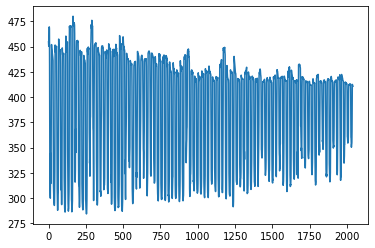

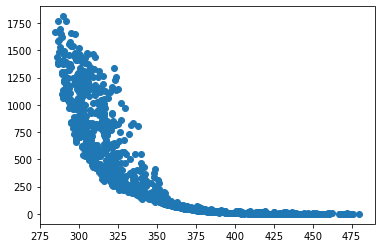

In [29]:
An = gasex_param['An'].tolist()

Cinew = []
for i in range(len(An)):
    Cinew.append(Ca - An[i] * (1 / gsc[i] + 1 / gbc[i]) * P)

plt.plot(Cinew)
plt.show()

plt.scatter(Cinew, PPFD)
plt.show()

In [16]:
EnergBal_param = {'gbw':[], 'gsw':[], 'gh':[], 'gv':[], 'gr':[], 'ghr':[], 'thermal_air':[], 'RH_eb':[], 'D':[], 'Ea':[], 'Icabs':[], 'NIR':[], 'Rabs':[], 'slope':[], 'Tlnew_eb':[], 'es_Tlnew':[], 'E':[], 'Emm':[], 'Cinew':[]}

for i in range(len(gbw)):
    EnergBal_param['gbw'].append(gbw[i])
    EnergBal_param['gsw'].append(gsw[i])
    EnergBal_param['gh'].append(gh[i])
    EnergBal_param['gv'].append(gv[i])
    EnergBal_param['gr'].append(gr[i])
    EnergBal_param['ghr'].append(ghr[i])
    EnergBal_param['thermal_air'].append(thermal_air[i])
    EnergBal_param['RH_eb'].append(RH[i])
    EnergBal_param['D'].append(D[i])
    EnergBal_param['Ea'].append(Ea[i])
    EnergBal_param['Icabs'].append(Icabs[i])
    EnergBal_param['NIR'].append(NIR[i])
    EnergBal_param['Rabs'].append(Rabs[i])
    EnergBal_param['slope'].append(slope[i])
    EnergBal_param['Tlnew_eb'].append(Tlnew_eb[i])
    EnergBal_param['es_Tlnew'].append(es_Tlnew[i])
    EnergBal_param['E'].append(E[i])
    EnergBal_param['Emm'].append(Emm[i])
    EnergBal_param['Cinew'].append(Cinew[i])

out_EnergBal_param = pd.DataFrame(EnergBal_param)
out_EnergBal_param.to_csv('EnergBal_param.csv')

leafassim

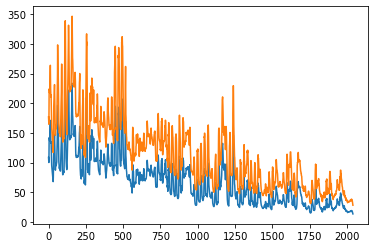

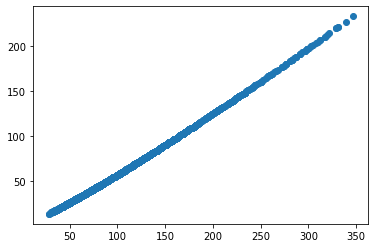

In [36]:
Vcmax = []
Jmax = []
GammaStar = []
Kc = []
Ko = []
TPU = []
Rd = []

def tempParam1(k25, Ha, Hd, Sv, temp):
    a = (1+np.exp((Sv*(25+KELVIN)-Hd)/(R*(25+KELVIN))))/(1+np.exp((Sv*(temp+KELVIN)- Hd)/(R*(temp+KELVIN))))
    b = np.exp((Ha / (R * (25.+KELVIN))) * (1 - (25.+KELVIN) / (temp + KELVIN)))
    return (k25 * b * a)

def tempParam2(k25, Ha, temp):
    return  k25 * np.exp((Ha / (R * (25.+KELVIN)) * (1 - (25.+KELVIN) / (KELVIN + temp)))) # --> arrhenius function

for i in range(len(Ta)):
    Vcmax.append(tempParam2(k25=Vcm25, Ha=Havcm, temp=Ta[i]))
    Jmax.append(tempParam1(k25=Jm25, Ha=Hajm, Hd=Hdjm, Sv=Svjm, temp=Ta[i]))
    GammaStar.append(tempParam2(k25=gamma25, Ha=Eagamma, temp=Ta[i]))
    Kc.append(tempParam2(k25=Kc25, Ha=Eac, temp=Ta[i]))
    Ko.append(tempParam2(k25=Ko25, Ha=Eao, temp=Ta[i]))
    TPU.append(tempParam2(k25=TPU25, Ha=EaTPU, temp=Ta[i]))
    Rd.append(tempParam2(k25=Rd25, Ha=Ear, temp=Ta[i]))

plt.plot(Vcmax)
plt.plot(Jmax)
plt.show()

plt.scatter(Jmax, Vcmax)
plt.show()

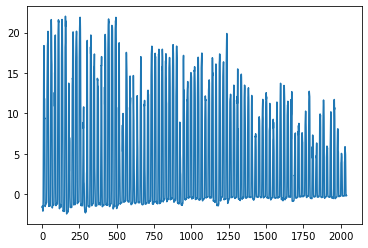

[]

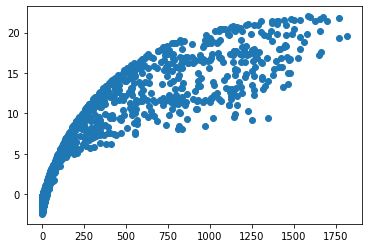

In [44]:
#assimilate

def minh(A, B, theta=0.7):  # hyperbolic minimum
    x = (A + B) * (A + B) - 4 * A * B * theta
    if (x < 0):
        res = min(A, B)
    else:
        res = ((A + B) - np.sqrt(x)) / (2 * theta)
    return res

J2 = []
J = []
for i in range(len(Jmax)):
    J2.append(Ic[i] * (1 - scatt) * (1 - f) / 2)
    J.append(((J2[i] + Jmax[i]) - np.sqrt((J2[i] + Jmax[i]) ** 2 - 4 * J2[i] * Jmax[i] * theta)) / (2 * theta))

## 광합성 모델식
Wc = []
Wj = []
Ws = []
Wp = []
W = []
Rd = []
An_as = []

for i in range(len(Vcmax)):
    Wc.append(Vcmax[i] * (Cinew[i] - GammaStar[i]) / (Cinew[i] + Kc[i] * (1 + O2 / Ko[i])))  # Rubisco-limited
    Wj.append(J[i] * (Cinew[i] - GammaStar[i]) / (4 * (Cinew[i] + 2 * GammaStar[i])))
    Ws.append(3 * TPU[i])
    Wp.append(minh(Wc[i], Wj[i], theta))
    W.append(min(Wp[i], Ws[i]))  # min(Wp, Ws)
    Rd.append(0.015 * Vcmax[i])  # Dark respiration from Collatz(1991)
    An_as.append(W[i] - Rd[i])

plt.plot(An_as)
plt.show()

plt.scatter(PPFD, An_as)
plt.plot()